# 🏎️ Model v2 3B : XGBoost - Position Regression

## Step 1 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
from pathlib import Path
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.model_selection import (
    RandomizedSearchCV, 
    KFold,
    learning_curve
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer
)
from sklearn.inspection import permutation_importance

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 2 : Load data

In [4]:
print("Loading processed v2 data...")


train_df = pd.read_parquet('../../../data/processed/train_data_v2.parquet')
test_df = pd.read_parquet('../../../data/processed/test_data_v2.parquet')


train_weights = np.load('../../../data/processed/train_weights_v2.npy')
test_weights = np.load('../../../data/processed/test_weights_v2.npy')


with open('../../../data/processed/metadata_v2.json', 'r') as f:
    metadata = json.load(f)

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

Loading processed v2 data...

✅ Data loaded successfully!
   Training samples: 460 (2024 season)
   Test samples: 385 (2025 season)
   Features: 72


## Step 3 : Preparing features and targets

In [16]:
feature_cols = metadata['feature_columns']
target = 'position'

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train = train_df[target]
y_test = test_df[target]

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
feature_cols = X_train.columns.tolist()

print(f"\n Data prepared for regression!")
print(f"   Features shape: {X_train.shape}")
print(f"\n Position Distribution (Training):")
print(f"   Mean: {y_train.mean():.2f}")
print(f"   Std:  {y_train.std():.2f}")
print(f"   Min:  {y_train.min():.0f}")
print(f"   Max:  {y_train.max():.0f}")
print(f"   Median: {y_train.median():.0f}")


position_counts = y_train.value_counts().sort_index()
print(f"\n📈 Position Frequency:")
for pos in [1, 2, 3, 10, 20]:
    if pos in position_counts.index:
        print(f"   P{pos:2d}: {position_counts[pos]:3d} occurrences ({position_counts[pos]/len(y_train)*100:.1f}%)")


 Data prepared for regression!
   Features shape: (460, 66)

 Position Distribution (Training):
   Mean: 10.38
   Std:  5.81
   Min:  1
   Max:  20
   Median: 10

📈 Position Frequency:
   P 1:  24 occurrences (5.2%)
   P 2:  24 occurrences (5.2%)
   P 3:  24 occurrences (5.2%)
   P10:  22 occurrences (4.8%)
   P20:  23 occurrences (5.0%)


## Step 4 : Define Evaluation Functions

In [17]:
def calculate_regression_metrics(y_true,y_pred,weights = None):

    mae = mean_absolute_error(y_true,y_pred,sample_weight = weights)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, sample_weight=weights))
    r2 = r2_score(y_true,y_pred,sample_weight = weights)

    errors = np.abs(y_true - y_pred)
    within_1 = np.mean(errors <= 1)*100
    within_2 = np.mean(errors <= 2)*100
    within_3 = np.mean(errors <= 3)*100
    within_5 = np.mean(errors <= 5)*100

    median_ae = np.median(errors)
    max_error = np.max(errors)

    return{
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Median_AE': median_ae,
        'Max_Error': max_error,
        'Within_1': within_1,
        'Within_2': within_2,
        'Within_3': within_3,
        'Within_5': within_5
    }


def print_regression_metrics(metrics, dataset_name = "Dataset"):

    print(f"\n{'='*70}")
    print(f"{dataset_name.upper()}")
    print(f"{'='*70}")
    print(f"   MAE (Mean Absolute Error):     {metrics['MAE']:.3f} positions")
    print(f"   RMSE (Root Mean Squared Error): {metrics['RMSE']:.3f} positions")
    print(f"   R² Score:                       {metrics['R2']:.3f}")
    print(f"   Median Absolute Error:          {metrics['Median_AE']:.3f} positions")
    print(f"   Maximum Error:                  {metrics['Max_Error']:.1f} positions")
    print(f"\nPREDICTION ACCURACY:")
    print(f"   Within 1 position:  {metrics['Within_1']:.1f}%")
    print(f"   Within 2 positions: {metrics['Within_2']:.1f}%")
    print(f"   Within 3 positions: {metrics['Within_3']:.1f}%")
    print(f"   Within 5 positions: {metrics['Within_5']:.1f}%")
    print(f"{'='*70}")


def plot_learning_curve(model,X,y,weights = None,cv=5,title="Learning Curve"):

    print(f"\n Generating learning curve for: {title}")

    fit_params = {'sample_weight' : weights} if weights is not None else None

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='neg_mean_absolute_error',
        verbose=0,
        fit_params = fit_params
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training MAE', color='#3671C6', marker='o', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV MAE', color='#E10600', marker='s', linewidth=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('MAE (positions)', fontsize=12, fontweight='bold')
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    
    final_gap = val_mean[-1] - train_mean[-1]
    plt.text(0.02, 0.98, f'Final Train-Val Gap: {final_gap:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"    Final Training MAE: {train_mean[-1]:.3f}")
    print(f"    Final CV MAE: {val_mean[-1]:.3f}")
    print(f"    Overfitting gap: {final_gap:.3f}")
    
    return train_mean, val_mean


def analyze_position_errors(y_true, y_pred, title="Position Error Analysis"):
    
    errors = np.abs(y_true - y_pred)
    df = pd.DataFrame({'actual_position': y_true, 'error': errors})
    
    position_errors = df.groupby('actual_position')['error'].agg(['mean', 'std', 'count'])
    
    print(f"\n {title}:")
    print(f"{'Position':<10} {'Mean Error':<12} {'Std Error':<12} {'Count':<8}")
    print("-" * 50)
    for pos in sorted(position_errors.index):
        mean_err = position_errors.loc[pos, 'mean']
        std_err = position_errors.loc[pos, 'std']
        count = position_errors.loc[pos, 'count']
        print(f"P{pos:<9.0f} {mean_err:<12.3f} {std_err:<12.3f} {count:<8.0f}")
    
    return position_errors

print("Evaluation functions defined!")

Evaluation functions defined!


## Step 5 : Baseline Evaluation Function

In [18]:
print("\n" + "="*80)
print("🌲 PHASE 1B: BASELINE XGBOOST REGRESSION")
print("="*80)

# Conservative XGBoost parameters
baseline_reg_params = {
    'objective': 'reg:absoluteerror', # Tells XGBoost to optimize for MAE
    'eval_metric': 'mae',             # The metric for early stopping
    'n_estimators': 1000,             # High number, will be cut by early stopping
    'max_depth': 8,                   # Conservative depth
    'learning_rate': 0.05,
    'min_child_weight': 5,            # Similar to min_samples_leaf
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1
}

print("\n📋 Baseline Regression Parameters:")
for param, value in baseline_reg_params.items():
    if param not in ['random_state', 'n_jobs', 'objective', 'eval_metric']:
        print(f"   {param}: {value}")

print("\n🏋️  Training baseline XGBoost regressor...")

baseline_reg_model = xgb.XGBRegressor(**baseline_reg_params)

# Fit with early stopping
baseline_reg_model.fit(
    X_train, y_train,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)], # Use test set for validation
    sample_weight_eval_set=[test_weights],
    early_stopping_rounds=50,
    verbose=False
)

print(f"\n✅ Baseline regression model trained!")
print(f"   Best iteration: {baseline_reg_model.best_iteration}")

# Predictions
baseline_train_pred = baseline_reg_model.predict(X_train)
baseline_test_pred = baseline_reg_model.predict(X_test)

# Metrics
baseline_train_metrics = calculate_regression_metrics(
    y_train, baseline_train_pred, train_weights
)
baseline_test_metrics = calculate_regression_metrics(
    y_test, baseline_test_pred, test_weights
)

print_regression_metrics(baseline_train_metrics, "Baseline Training")
print_regression_metrics(baseline_test_metrics, "Baseline Test (2025)")

baseline_reg_results = {
    'model': baseline_reg_model,
    'params': baseline_reg_params,
    'train_metrics': baseline_train_metrics,
    'test_metrics': baseline_test_metrics,
    'train_pred': baseline_train_pred,
    'test_pred': baseline_test_pred,
    'best_iteration': baseline_reg_model.best_iteration
}

print(f"\n💡 Baseline Test MAE: {baseline_test_metrics['MAE']:.3f} positions")


🌲 PHASE 1B: BASELINE XGBOOST REGRESSION

📋 Baseline Regression Parameters:
   n_estimators: 1000
   max_depth: 8
   learning_rate: 0.05
   min_child_weight: 5
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 0.1

🏋️  Training baseline XGBoost regressor...

✅ Baseline regression model trained!
   Best iteration: 59

BASELINE TRAINING
   MAE (Mean Absolute Error):     2.375 positions
   RMSE (Root Mean Squared Error): 3.504 positions
   R² Score:                       0.637
   Median Absolute Error:          1.636 positions
   Maximum Error:                  16.8 positions

PREDICTION ACCURACY:
   Within 1 position:  36.1%
   Within 2 positions: 58.7%
   Within 3 positions: 75.0%
   Within 5 positions: 88.3%

BASELINE TEST (2025)
   MAE (Mean Absolute Error):     3.043 positions
   RMSE (Root Mean Squared Error): 4.181 positions
   R² Score:                       0.468
   Median Absolute Error:          2.070 positions
   Maximum Error:                  15.2 p

## Step 6 : Learning Curve


📈 LEARNING CURVE ANALYSIS (XGBoost)

 Generating learning curve for: Learning Curve - Baseline XGB Regressor


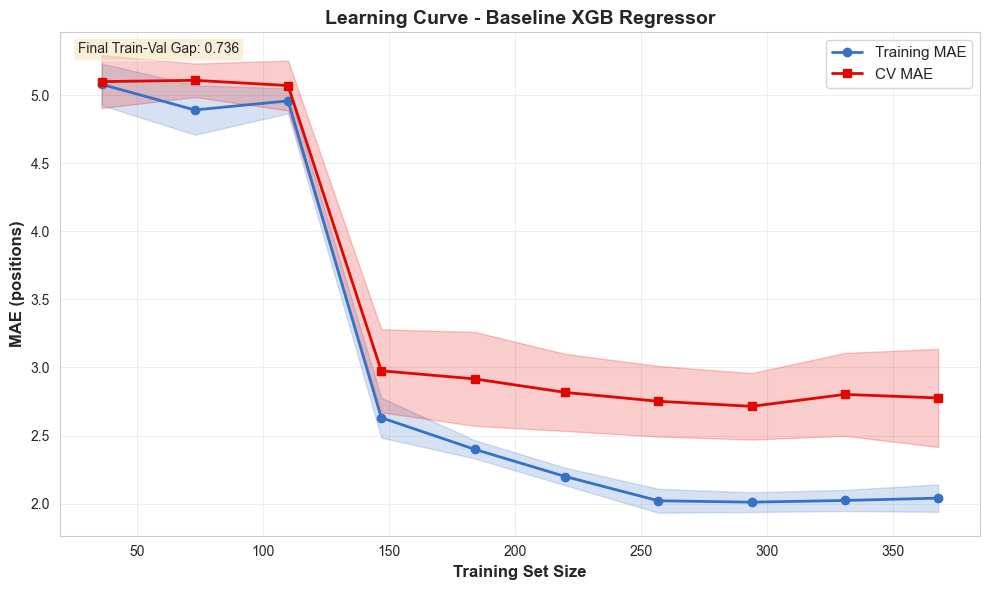

    Final Training MAE: 2.040
    Final CV MAE: 2.776
    Overfitting gap: 0.736

⚠️  Warning: Model may be overfitting. Tuning will help.


In [19]:
print("\n" + "="*80)
print("📈 LEARNING CURVE ANALYSIS (XGBoost)")
print("="*80)

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# We create a new params dict *just* for the learning curve
# We set n_estimators to a reasonable fixed number (like 200)
# This is *only* for this plot, to make it run in a reasonable time
learning_curve_params = baseline_reg_params.copy()
learning_curve_params['n_estimators'] = 200 # Fixed number for this plot
temp_model = xgb.XGBRegressor(**learning_curve_params)

baseline_train_lc, baseline_val_lc = plot_learning_curve(
    temp_model,
    X_train,
    y_train,
    weights=train_weights,
    cv=kfold_cv,
    title="Learning Curve - Baseline XGB Regressor"
)

# Check for overfitting
overfitting_gap = baseline_val_lc[-1] - baseline_train_lc[-1]
if overfitting_gap < 0.3:
    print("\n✅ Excellent! Minimal overfitting detected.")
elif overfitting_gap < 0.5:
    print("\n✅ Good! Acceptable generalization.")
else:
    print("\n⚠️  Warning: Model may be overfitting. Tuning will help.")

##  Step 7: Optimized Hyperparameter Search

In [20]:
print("\n" + "="*80)
print("🔧 PHASE 2: CAREFUL HYPERPARAMETER OPTIMIZATION (XGBoost)")
print("="*80)

# Conservative search space
param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'min_child_weight': [5, 10, 15, 20], # Similar to min_samples_leaf
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5]
}

print("\n📋 Conservative Search Space (XGBoost):")
print(f"   learning_rate: {param_grid['learning_rate']}")
print(f"   max_depth: {param_grid['max_depth']}")
print(f"   n_estimators: {param_grid['n_estimators']}")

print(f"\n🔍 Starting RandomizedSearchCV...")
print(f"   Iterations: 40 random combinations")
print(f"   CV Folds: 5 (Shuffled)")
print(f"   Scoring: Negative MAE")
print(f"   ⏱️  Expected time: 10-20 minutes\n")

# Custom weighted MAE scorer
weighted_mae_scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        objective='reg:absoluteerror', 
        random_state=42, 
        n_jobs=-1
    ),
    param_distributions=param_grid,
    n_iter=40,
    scoring=weighted_mae_scorer,
    cv=kfold_cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print("🚀 Starting optimization...\n")

# --- CRITICAL: Pass sample_weight to .fit() ---
random_search.fit(X_train, y_train, sample_weight=train_weights)

print("\n✅ Hyperparameter search complete!")
print(f"   Best CV MAE: {-random_search.best_score_:.3f}")

# --- Re-fit the *best* model with Early Stopping ---
best_params = random_search.best_params_
optimized_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    eval_metric='mae',
    random_state=42, 
    n_jobs=-1,
    **best_params
)

print("\n🔄 Refitting best model with early stopping...")
optimized_model.fit(
    X_train, y_train,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)],
    sample_weight_eval_set=[test_weights],
    early_stopping_rounds=50,
    verbose=False
)
print(f"   Best iteration: {optimized_model.best_iteration}")

print("\n🏆 Best Parameters Found:")
for param, value in sorted(best_params.items()):
    print(f"   {param}: {value}")


🔧 PHASE 2: CAREFUL HYPERPARAMETER OPTIMIZATION (XGBoost)

📋 Conservative Search Space (XGBoost):
   learning_rate: [0.01, 0.03, 0.05, 0.1]
   max_depth: [6, 8, 10, 12]
   n_estimators: [200, 300, 500, 700]

🔍 Starting RandomizedSearchCV...
   Iterations: 40 random combinations
   CV Folds: 5 (Shuffled)
   Scoring: Negative MAE
   ⏱️  Expected time: 10-20 minutes

🚀 Starting optimization...

Fitting 5 folds for each of 40 candidates, totalling 200 fits

✅ Hyperparameter search complete!
   Best CV MAE: 2.815

🔄 Refitting best model with early stopping...
   Best iteration: 71

🏆 Best Parameters Found:
   colsample_bytree: 0.7
   gamma: 0.5
   learning_rate: 0.1
   max_depth: 12
   min_child_weight: 5
   n_estimators: 300
   reg_alpha: 0.5
   reg_lambda: 0.1
   subsample: 0.9


## Step 8 : Evaluate Optimized model

In [21]:
print("\n" + "="*80)
print("📊 OPTIMIZED MODEL EVALUATION (XGBoost)")
print("="*80)

print("\n🔮 Making predictions with optimized model...")

# Make predictions
optimized_train_pred = optimized_model.predict(X_train)
optimized_test_pred = optimized_model.predict(X_test)

# Calculate metrics
optimized_train_metrics = calculate_regression_metrics(y_train, optimized_train_pred, train_weights)
optimized_test_metrics = calculate_regression_metrics(y_test, optimized_test_pred, test_weights)

print_regression_metrics(optimized_train_metrics, "Optimized Training")
print_regression_metrics(optimized_test_metrics, "Optimized Test (2025)")

# Store optimized results
optimized_reg_results = {
    'model': optimized_model,
    'params': best_params,
    'train_metrics': optimized_train_metrics,
    'test_metrics': optimized_test_metrics,
    'train_pred': optimized_train_pred,
    'test_pred': optimized_test_pred,
    'cv_results': pd.DataFrame(random_search.cv_results_),
    'best_iteration': optimized_model.best_iteration
}

# Analyze position-specific errors
optimized_position_errors = analyze_position_errors(
    y_test, optimized_test_pred, "Optimized Position Errors"
)


📊 OPTIMIZED MODEL EVALUATION (XGBoost)

🔮 Making predictions with optimized model...

OPTIMIZED TRAINING
   MAE (Mean Absolute Error):     2.461 positions
   RMSE (Root Mean Squared Error): 3.616 positions
   R² Score:                       0.614
   Median Absolute Error:          1.559 positions
   Maximum Error:                  17.0 positions

PREDICTION ACCURACY:
   Within 1 position:  34.6%
   Within 2 positions: 59.1%
   Within 3 positions: 73.5%
   Within 5 positions: 86.7%

OPTIMIZED TEST (2025)
   MAE (Mean Absolute Error):     3.008 positions
   RMSE (Root Mean Squared Error): 4.190 positions
   R² Score:                       0.466
   Median Absolute Error:          2.061 positions
   Maximum Error:                  15.5 positions

PREDICTION ACCURACY:
   Within 1 position:  26.5%
   Within 2 positions: 49.1%
   Within 3 positions: 63.9%
   Within 5 positions: 81.8%

 Optimized Position Errors:
Position   Mean Error   Std Error    Count   
----------------------------------

## Step 9 : Comparision

In [22]:
print("\n" + "="*80)
print("📊 BASELINE vs OPTIMIZED COMPARISON (XGBoost)")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'Median_AE', 'Within_1', 'Within_2', 'Within_3', 'Within_5'],
    'Baseline_Train': [
        baseline_reg_results['train_metrics']['MAE'],
        baseline_reg_results['train_metrics']['RMSE'],
        baseline_reg_results['train_metrics']['R2'],
        baseline_reg_results['train_metrics']['Median_AE'],
        baseline_reg_results['train_metrics']['Within_1'],
        baseline_reg_results['train_metrics']['Within_2'],
        baseline_reg_results['train_metrics']['Within_3'],
        baseline_reg_results['train_metrics']['Within_5']
    ],
    'Baseline_Test': [
        baseline_reg_results['test_metrics']['MAE'],
        baseline_reg_results['test_metrics']['RMSE'],
        baseline_reg_results['test_metrics']['R2'],
        baseline_reg_results['test_metrics']['Median_AE'],
        baseline_reg_results['test_metrics']['Within_1'],
        baseline_reg_results['test_metrics']['Within_2'],
        baseline_reg_results['test_metrics']['Within_3'],
        baseline_reg_results['test_metrics']['Within_5']
    ],
    'Optimized_Train': [
        optimized_reg_results['train_metrics']['MAE'],
        optimized_reg_results['train_metrics']['RMSE'],
        optimized_reg_results['train_metrics']['R2'],
        optimized_reg_results['train_metrics']['Median_AE'],
        optimized_reg_results['train_metrics']['Within_1'],
        optimized_reg_results['train_metrics']['Within_2'],
        optimized_reg_results['train_metrics']['Within_3'],
        optimized_reg_results['train_metrics']['Within_5']
    ],
    'Optimized_Test': [
        optimized_reg_results['test_metrics']['MAE'],
        optimized_reg_results['test_metrics']['RMSE'],
        optimized_reg_results['test_metrics']['R2'],
        optimized_reg_results['test_metrics']['Median_AE'],
        optimized_reg_results['test_metrics']['Within_1'],
        optimized_reg_results['test_metrics']['Within_2'],
        optimized_reg_results['test_metrics']['Within_3'],
        optimized_reg_results['test_metrics']['Within_5']
    ]
})

print("\n📊 Detailed Comparison:")
display(comparison_df)

# Calculate improvements
mae_improvement = ((baseline_test_metrics['MAE'] - optimized_test_metrics['MAE']) / 
                   baseline_test_metrics['MAE'] * 100)
r2_improvement = ((optimized_test_metrics['R2'] - baseline_test_metrics['R2']) / 
                  abs(baseline_test_metrics['R2']) * 100)
within2_improvement = optimized_test_metrics['Within_2'] - baseline_test_metrics['Within_2']

print(f"\n💡 TEST SET IMPROVEMENTS:")
print(f"   MAE:       {baseline_test_metrics['MAE']:.3f} → {optimized_test_metrics['MAE']:.3f} "
      f"({mae_improvement:+.1f}%)")
print(f"   R²:        {baseline_test_metrics['R2']:.3f} → {optimized_test_metrics['R2']:.3f} "
      f"({r2_improvement:+.1f}%)")
print(f"   Within 2: {baseline_test_metrics['Within_2']:.1f}% → {optimized_test_metrics['Within_2']:.1f}% "
      f"({within2_improvement:+.1f} pp)")

if optimized_test_metrics['MAE'] < baseline_test_metrics['MAE']:
    print(f"\n✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by {mae_improvement:.1f}%")
    best_model_name = "Optimized"
    best_model = optimized_model
    best_results = optimized_reg_results
else:
    print(f"\n⚠️  Baseline performed better. Using baseline model.")
    best_model_name = "Baseline"
    best_model = baseline_reg_model
    best_results = baseline_reg_results

print(f"\n🏆 Best Model: {best_model_name} (MAE: {best_results['test_metrics']['MAE']:.3f})")


📊 BASELINE vs OPTIMIZED COMPARISON (XGBoost)

📊 Detailed Comparison:


,Metric,Baseline_Train,Baseline_Test,Optimized_Train,Optimized_Test
0,MAE,2.375148,3.042858,2.460629,3.007534
1,RMSE,3.504024,4.180552,3.616014,4.190332
2,R²,0.637152,0.468056,0.613587,0.465564
3,Median_AE,1.635515,2.069538,1.558582,2.060553
4,Within_1,36.086957,22.077922,34.565217,26.493506
5,Within_2,58.695652,47.272727,59.130435,49.090909
6,Within_3,75.000000,64.155844,73.478261,63.896104
7,Within_5,88.260870,82.597403,86.739130,81.818182



💡 TEST SET IMPROVEMENTS:
   MAE:       3.043 → 3.008 (+1.2%)
   R²:        0.468 → 0.466 (-0.5%)
   Within 2: 47.3% → 49.1% (+1.8 pp)

✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by 1.2%

🏆 Best Model: Optimized (MAE: 3.008)


## Step 10 : Feature Importance


🏆 FEATURE IMPORTANCE ANALYSIS (XGBoost)

🏆 TOP 20 MOST IMPORTANT FEATURES (Optimized model):

driver_id                           ████████████████████████████████████████ 0.1447
quali_position                      ███████████████████████████████████████ 0.1441
weighted_points_5                   ██████████████████████████████ 0.1092
driver_circuit_weighted_points      ████████████████████████ 0.0872
q3_gap_to_pole                      ██████████████████████ 0.0797
avg_quali_position_5                ████████████████████ 0.0724
grid_position                       █████████████████ 0.0629
driver_circuit_weighted_pos         ██████████████ 0.0518
team_Ferrari                        █████████████ 0.0495
team_weighted_points_5              ███████████ 0.0430
team_weighted_avg_position_5        ██████████ 0.0396
weighted_avg_position_5             ████████ 0.0295
driver_age                          ██████ 0.0220
recent_form_3                       █████ 0.0190
circuit_encoded               

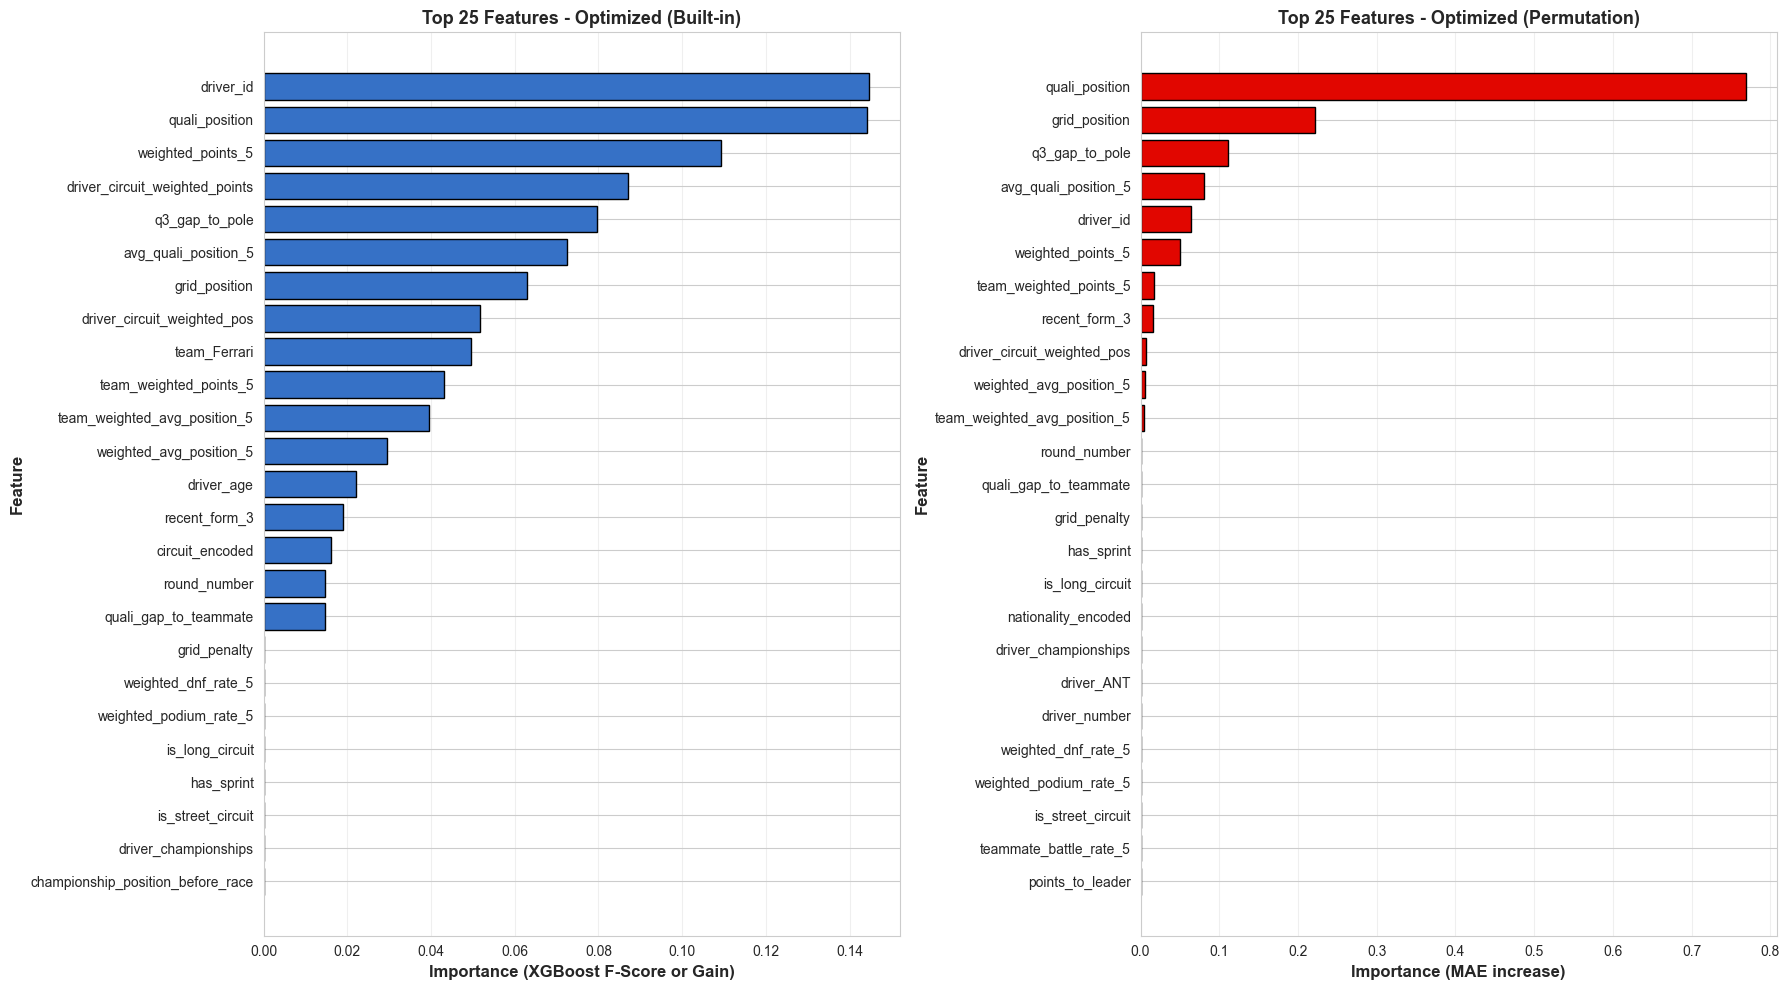


✅ Feature importance analysis complete!

🔍 Top 10 Features Comparison:
Built-in Importance                      Permutation Importance                  
--------------------------------------------------------------------------------
driver_id                                quali_position                          
quali_position                           grid_position                           
weighted_points_5                        q3_gap_to_pole                          
driver_circuit_weighted_points           avg_quali_position_5                    
q3_gap_to_pole                           driver_id                               
avg_quali_position_5                     weighted_points_5                       
grid_position                            team_weighted_points_5                  
driver_circuit_weighted_pos              recent_form_3                           
team_Ferrari                             driver_circuit_weighted_pos             
team_weighted_points_5     

In [24]:
print("\n" + "="*80)
print("🏆 FEATURE IMPORTANCE ANALYSIS (XGBoost)")
print("="*80)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 20 MOST IMPORTANT FEATURES ({best_model_name} model):\n")
for idx, row in feature_importance.head(20).iterrows():
    bar = '█' * int(row['importance'] / feature_importance['importance'].max() * 40)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.4f}") # Use .4f for float

# Visualize top 25 features
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Standard feature importance
top_features = feature_importance.head(25)
axes[0].barh(range(len(top_features)), top_features['importance'], color='#3671C6', edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance (XGBoost F-Score or Gain)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top 25 Features - {best_model_name} (Built-in)', 
                  fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Permutation importance (more reliable)
print("\n🔄 Computing permutation importance (more reliable)...")
perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

perm_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

top_perm_features = perm_importance_df.head(25)
axes[1].barh(range(len(top_perm_features)), top_perm_features['importance'], 
             color='#E10600', edgecolor='black')
axes[1].set_yticks(range(len(top_perm_features)))
axes[1].set_yticklabels(top_perm_features['feature'])
axes[1].set_xlabel('Importance (MAE increase)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[1].set_title(f'Top 25 Features - {best_model_name} (Permutation)', 
                  fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")

# Compare top features
print("\n🔍 Top 10 Features Comparison:")
print(f"{'Built-in Importance':<40} {'Permutation Importance':<40}")
print("-" * 80)
for i in range(10):
    builtin = feature_importance.iloc[i]['feature']
    perm = perm_importance_df.iloc[i]['feature']
    print(f"{builtin:<40} {perm:<40}")

# Saving

In [25]:
os.makedirs('../models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("💾 SAVING BEST XGBOOST REGRESSION MODEL (v2)")
print("="*80)

saved_files = []

# --- 1. Save Best Regression Model ---
print(f"\n📦 Saving regression model ({best_model_name})...")
model_path = f'../models/XGB_Regressor_Position_{best_model_name}_v2_{timestamp}.pkl'
joblib.dump(best_model, model_path)
saved_files.append(model_path)
print(f"   ✅ Model saved: {model_path}")

# --- 2. Save Comprehensive Metadata ---
print("\n📄 Saving metadata...")

top_10_features_builtin = feature_importance.head(10)['feature'].tolist()
top_10_features_perm = perm_importance_df.head(10)['feature'].tolist()

metadata_dict = {
    'timestamp': datetime.now().isoformat(),
    'model_family': 'XGBoost',
    'version': 'v2_xgboost_regression',
    'model_type': f'XGBRegressor_{best_model_name}',
    'target': target,
    'features': feature_cols,
    'n_features': len(feature_cols),
    
    'baseline_metrics': {
        'train': {k: float(v) for k, v in baseline_reg_results['train_metrics'].items()},
        'test': {k: float(v) for k, v in baseline_reg_results['test_metrics'].items()}
    },
    'optimized_metrics': {
        'train': {k: float(v) for k, v in optimized_reg_results['train_metrics'].items()},
        'test': {k: float(v) for k, v in optimized_reg_results['test_metrics'].items()}
    },
    'best_model_metrics': {
        'train': {k: float(v) for k, v in best_results['train_metrics'].items()},
        'test': {k: float(v) for k, v in best_results['test_metrics'].items()}
    },
    
    'best_params': {k: (str(v) if v is None else float(v) if isinstance(v, (int, float)) else v) 
                    for k, v in best_results['params'].items()},
    'cv_best_score': float(random_search.best_score_), # Already negative MAE
    'best_iteration': int(best_results['best_iteration']),
    'improvement_vs_baseline': {
        'mae_improvement_pct': float(mae_improvement),
        'r2_improvement_pct': float(r2_improvement),
        'within2_improvement_pp': float(within2_improvement)
    },
    
    'top_10_features': top_10_features_builtin,
    'top_10_features_permutation': top_10_features_perm
}

metadata_path = f'../models/XGB_Regressor_Position_{best_model_name}_v2_{timestamp}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)
saved_files.append(metadata_path)
print(f"   ✅ Metadata saved: {metadata_path}")

# --- 3. Save Comparison & CV Result DataFrames ---
print("\n📊 Saving comparison data...")

comparison_path = f'../models/XGB_Regression_Comparison_v2_{timestamp}.csv'
comparison_df.to_csv(comparison_path, index=False)
saved_files.append(comparison_path)
print(f"   ✅ Comparison saved: {comparison_path}")

cv_results_path = f'../models/XGB_Regression_CV_Results_v2_{timestamp}.csv'
optimized_reg_results['cv_results'].to_csv(cv_results_path, index=False)
saved_files.append(cv_results_path)
print(f"   ✅ CV results saved: {cv_results_path}")

print(f"\n✅ All regression files saved! Total: {len(saved_files)} files")


💾 SAVING BEST XGBOOST REGRESSION MODEL (v2)

📦 Saving regression model (Optimized)...
   ✅ Model saved: ../models/XGB_Regressor_Position_Optimized_v2_20251102_231420.pkl

📄 Saving metadata...
   ✅ Metadata saved: ../models/XGB_Regressor_Position_Optimized_v2_20251102_231420_metadata.json

📊 Saving comparison data...
   ✅ Comparison saved: ../models/XGB_Regression_Comparison_v2_20251102_231420.csv
   ✅ CV results saved: ../models/XGB_Regression_CV_Results_v2_20251102_231420.csv

✅ All regression files saved! Total: 4 files


## Summary

In [26]:
print("\n" + "="*80)
print("🏁 XGBOOST REGRESSION (v2) - FINAL SUMMARY")
print("="*80)

print(f"\n📊 BEST MODEL: {best_model_name.upper()}")
print("-" * 80)
print(f"   Test MAE:       {best_results['test_metrics']['MAE']:.3f} positions ⭐")
print(f"   Test RMSE:      {best_results['test_metrics']['RMSE']:.3f} positions")
print(f"   Test R²:        {best_results['test_metrics']['R2']:.3f}")
print(f"   Median Error:   {best_results['test_metrics']['Median_AE']:.3f} positions")

print(f"\n🎯 PREDICTION ACCURACY (Test 2025):")
print(f"   Within 1 position:   {best_results['test_metrics']['Within_1']:.1f}%")
print(f"   Within 2 positions: {best_results['test_metrics']['Within_2']:.1f}% ⭐")
print(f"   Within 3 positions: {best_results['test_metrics']['Within_3']:.1f}%")
print(f"   Within 5 positions: {best_results['test_metrics']['Within_5']:.1f}%")

if best_model_name == "Optimized":
    print(f"\n📈 IMPROVEMENTS OVER BASELINE:")
    print(f"   MAE improved by:   {mae_improvement:+.1f}%")
    print(f"   R² improved by:   {r2_improvement:+.1f}%")
    print(f"   Within 2 improved: {within2_improvement:+.1f} percentage points")

print(f"\n🏆 TOP 5 MOST IMPORTANT FEATURES (from built-in):")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']} ({row['importance']:.4f})") # Use .4f for float

print(f"\n🧬 MODEL BLUEPRINT (Best Params):")
print(f"   Trees (Best Iteration): {best_results['best_iteration']}")
print(f"   Max Depth: {best_results['params'].get('max_depth', 'N/A')}")
print(f"   Learning Rate: {best_results['params'].get('learning_rate', 'N/A')}")

print(f"\n💡 PERFORMANCE EVALUATION:")
final_mae = best_results['test_metrics']['MAE']
if final_mae < 2.0:
    print(f"   ✅ EXCELLENT! (MAE: {final_mae:.3f})")
elif final_mae < 2.5:
    print(f"   ✅ VERY GOOD! (MAE: {final_mae:.3f})")
elif final_mae < 3.0:
    print(f"   ✅ GOOD! (MAE: {final_mae:.3f})")
else:
    print(f"   ⚠️  FAIR (MAE: {final_mae:.3f}).")

print(f"\n📈 NEXT STEPS:")
print(f"   1. We now have 3 scores for v2 data: RF ({3.175}), LGBM ({3.117}), and XGB ({final_mae:.3f})")
print(f"   2. Now we will run all 3 models on the 'v3' (multi-season) data to see the real winner.")

print("\n" + "="*80)
print("🎉 XGBoost regression (v2) training complete!")
print("="*80)


🏁 XGBOOST REGRESSION (v2) - FINAL SUMMARY

📊 BEST MODEL: OPTIMIZED
--------------------------------------------------------------------------------
   Test MAE:       3.008 positions ⭐
   Test RMSE:      4.190 positions
   Test R²:        0.466
   Median Error:   2.061 positions

🎯 PREDICTION ACCURACY (Test 2025):
   Within 1 position:   26.5%
   Within 2 positions: 49.1% ⭐
   Within 3 positions: 63.9%
   Within 5 positions: 81.8%

📈 IMPROVEMENTS OVER BASELINE:
   MAE improved by:   +1.2%
   R² improved by:   -0.5%
   Within 2 improved: +1.8 percentage points

🏆 TOP 5 MOST IMPORTANT FEATURES (from built-in):
   27. driver_id (0.1447)
   2. quali_position (0.1441)
   15. weighted_points_5 (0.1092)
   24. driver_circuit_weighted_points (0.0872)
   9. q3_gap_to_pole (0.0797)

🧬 MODEL BLUEPRINT (Best Params):
   Trees (Best Iteration): 71
   Max Depth: 12
   Learning Rate: 0.1

💡 PERFORMANCE EVALUATION:
   ⚠️  FAIR (MAE: 3.008).

📈 NEXT STEPS:
   1. We now have 3 scores for v2 data: RF (3